# Performance Under Fading Channels

This notebook will look at how the FCN architecture performs under fading channels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy import signal

from training_helpers import *

In [2]:
def calc_preambles(preamble_length=16, snr_range=np.arange(-10,11), cfo=None, num_iter=5000):
    
    base_ders, expert_ders = test_baselines(signal.max_len_seq(6)[0][:preamble_length], snr_range=snr_range, 
                                            num_iter=num_iter, payload=128, signal_length=200, random_offset=True, 
                                            carrier_offset=cfo, add_channel=True, awgn_measured=False)
    
    result = {'base_ders': base_ders,
              'expert_ders': expert_ders,
              'snr_range': snr_range}
    
    print(f"saving to: baselines/length_{preamble_length}_flat_fading.pt")
    torch.save(result, f'baselines/length_{preamble_length}_flat_fading.pt')

## Define flat fading baselines

In [3]:
preamble_lengths = [8, 16, 32]
snr_range=np.arange(-5,31)

In [4]:
for length in preamble_lengths:
    calc_preambles(preamble_length=length, snr_range=snr_range, num_iter=15000)

saving to: baselines/length_8_flat_fading.pt
saving to: baselines/length_16_flat_fading.pt
saving to: baselines/length_32_flat_fading.pt


In [5]:
base_ders_8 = torch.load('baselines/length_8_flat_fading.pt')['base_ders']
expert_ders_8 = torch.load('baselines/length_8_flat_fading.pt')['expert_ders']

base_ders_16 = torch.load('baselines/length_16_flat_fading.pt')['base_ders']
expert_ders_16 = torch.load('baselines/length_16_flat_fading.pt')['expert_ders']

base_ders_32 = torch.load('baselines/length_32_flat_fading.pt')['base_ders']
expert_ders_32 = torch.load('baselines/length_32_flat_fading.pt')['expert_ders']

Text(0.5, 0, 'SNR, dB')

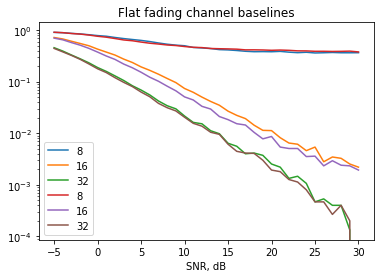

In [6]:
# plt.semilogy(snr_range, baseline_ders_awgn)
plt.semilogy(snr_range, base_ders_8)
plt.semilogy(snr_range, base_ders_16)
plt.semilogy(snr_range, base_ders_32)
plt.semilogy(snr_range, expert_ders_8)
plt.semilogy(snr_range, expert_ders_16)
plt.semilogy(snr_range, expert_ders_32)
plt.legend(('8', '16', '32', '8', '16', '32'))
plt.title('Flat fading channel baselines')
plt.xlabel('SNR, dB')

## The FCN architecture

In [4]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers, num_filters, width):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [8]:
train_snrs = [10, 5, 0]
reg = 0.001

num_layers = 3
num_filters = 32
filter_width = 35

for preamble_length, train_snr in zip(preamble_lengths, train_snrs):
    models = torch.load(f"models/{preamble_length}_preamble_{train_snr}_cfo_True_CrossEntropyLoss_reg_{reg}.pt")
    results = []
    for model in models:
        detector = preamble_detector(num_layers,num_filters,filter_width)
        detector.load_state_dict(model['weights'])

        ders = test_detector(detector, signal.max_len_seq(6)[0][:preamble_length], snr_range=snr_range, num_iter=15000, 
                             add_phase_offset=True, carrier_offset=None, add_channel=True, awgn_measured=False)

        result = {"ders": ders,
                    "model": model,
                    "snr_range": snr_range}

        results.append(result)
    torch.save(results, f"results/ders/fcn_{preamble_length}_flat_fading.pt")

In [5]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

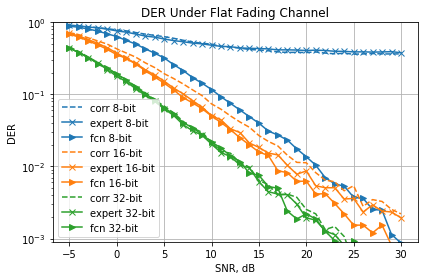

In [11]:
baselines = [base_ders_8, base_ders_16, base_ders_32]
experts = [expert_ders_8, expert_ders_16, expert_ders_32]

for i, (preamble_length, train_snr) in enumerate(zip(preamble_lengths, train_snrs)):
    results = torch.load(f"results/ders/fcn_{preamble_length}_flat_fading.pt")
    best, worst = find_best_worst(results)
    plt.semilogy(snr_range, baselines[i], f'--C{i}')
    plt.semilogy(snr_range, experts[i], f'-xC{i}')
    plt.semilogy(snr_range, results[best]['ders'], f'->C{i}')

plt.grid()
plt.ylim([0.0009, 1])
plt.xlabel('SNR, dB'); plt.ylabel('DER')
plt.title('DER Under Flat Fading Channel')
plt.legend(['corr 8-bit', 'expert 8-bit', 'fcn 8-bit', 
            'corr 16-bit', 'expert 16-bit', 'fcn 16-bit', 
            'corr 32-bit', 'expert 32-bit', 'fcn 32-bit'])
plt.tight_layout()
# plt.savefig('figures/ders_fading.png', dpi=300, bbox_inches='tight')

## Multipath Fading


<div class="alert alert-block alert-info"> <b>NOTE</b> For this part you will need to have an installation of MATLAB with the Python engine set up in order to use the rician channel objects.</div>

In [6]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [7]:
def generate_multipath_data(snr_range, preamble_length=32, num_iter=500, signal_length=200,
                            delays = [0, 5e-6, 10e-6], gains = [-6, 0, -3], K = [10]):

    dataset = {}
    
    for snr in snr_range:
        data, labels = map(np.array, eng.generate_bursty_rand_test_data(num_iter, 128, matlab.double([snr]), matlab.double([32]), 200-128-32, True, 
                                                                'multipath rician', matlab.double(delays), matlab.double(gains), matlab.double(K), nargout=2))
        labels = labels-1 # matlab does 1 based indexing, so we subtract for python land

        dataset[snr] = (data, labels)
        
    return dataset

In [8]:
for length in preamble_lengths:
    dataset = generate_multipath_data(snr_range, preamble_length=length, num_iter=8192, signal_length=200)
    save_dir = f"data/length_{length}_multipath_fading.pt"
    
    print(f"Saving to {save_dir}")
    torch.save(dataset, save_dir)

Saving to data/length_8_multipath_fading.pt
Saving to data/length_16_multipath_fading.pt
Saving to data/length_32_multipath_fading.pt


In [9]:
def test_multipath_baseline(snr_range, preamble_length, dataset):

    preamble_seq = signal.max_len_seq(6)[0][:preamble_length]
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
    
    corr_ers = np.zeros(len(snr_range),)
    expert_ers = np.zeros(len(snr_range),)

    for idx, snr in enumerate(snr_range):
        corr_err, expert_err = float(0), float(0)
        
        data, labels = dataset[snr]

        for x,y in zip(data, labels):
            # Calculate baselines
            correlation = np.abs(np.correlate(x, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Get corrective terms
            r_i = np.convolve(np.abs(x.real), np.ones(len(preamble)), 'valid')
            r_q = np.convolve(np.abs(x.imag), np.ones(len(preamble)), 'valid')
            r_iq = np.convolve(np.abs(x.real+x.imag), np.ones(len(preamble)), 'valid')/np.sqrt(2)
            r_i_q = np.convolve(np.abs(x.real-x.imag), np.ones(len(preamble)), 'valid')/np.sqrt(2)

            corr_expert = correlation - np.max((r_i, r_q, r_iq, r_i_q), axis=0)
            y_expert = np.argmax(corr_expert[:-len(preamble_seq)])

            corr_err += (y_corr != y)
            expert_err += (y_expert != y)
        
        corr_ers[idx] = corr_err/len(data)
        expert_ers[idx] = expert_err/len(data)
        
    return corr_ers, expert_ers

In [10]:
dataset_32 = torch.load('data/length_32_multipath_fading.pt')
corr_ders_32, expert_ders_32 = test_multipath_baseline(snr_range, 32, dataset_32)

dataset_16 = torch.load('data/length_16_multipath_fading.pt')
corr_ders_16, expert_ders_16 = test_multipath_baseline(snr_range, 16, dataset_16)

dataset_8 = torch.load('data/length_8_multipath_fading.pt')
corr_ders_8, expert_ders_8 = test_multipath_baseline(snr_range, 8, dataset_8)

In [14]:
def test_multipath_detector(detector, snr_range, preamble_length, dataset):

    detector.cuda()
    
    err_vec = np.zeros(len(snr_range),)

    for idx, snr in enumerate(snr_range):
        nn_err = float(0)
        
        data, labels = dataset[snr]
        data = (data/np.max(np.abs(data),axis=1)[:,None])

        labels = labels.astype(int)

        x,y = preprocess(data, labels, gpu=True)

        inference_dataset = torch.utils.data.TensorDataset(x, y)
        inference_loader = torch.utils.data.DataLoader(inference_dataset, batch_size=256, shuffle=False)

        for x_infer, y_infer in inference_loader:
            y_hat = detector(x_infer).detach()

            nn_err += torch.sum(y_hat.argmax(axis=1) != y_infer.argmax(axis=1))

        err_vec[idx] = nn_err/len(data)

    detector.cpu()
    
    return err_vec

In [15]:
train_snrs = [10, 5, 0]
reg = 0.001

num_layers = 3
num_filters = 32
filter_width = 35

datasets = [dataset_8, dataset_16, dataset_32]

for preamble_length, train_snr, dataset in zip(preamble_lengths, train_snrs, datasets):
    models = torch.load(f"models/{preamble_length}_preamble_{train_snr}_cfo_True_CrossEntropyLoss_reg_{reg}.pt")
    results = []
    for model in models:
        detector = preamble_detector(num_layers,num_filters,filter_width)
        detector.load_state_dict(model['weights'])

        ders = test_multipath_detector(detector, snr_range, preamble_length, dataset)

        result = {"ders": ders,
                    "model": model,
                    "snr_range": snr_range}

        results.append(result)
    torch.save(results, f"results/ders/fcn_{preamble_length}_multipath_fading.pt")

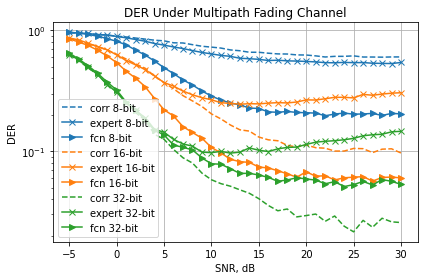

In [17]:
baselines = [corr_ders_8, corr_ders_16, corr_ders_32]
experts = [expert_ders_8, expert_ders_16, expert_ders_32]

for i, (preamble_length, train_snr) in enumerate(zip(preamble_lengths, train_snrs)):
    results = torch.load(f"results/ders/fcn_{preamble_length}_multipath_fading.pt")
    best, worst = find_best_worst(results)
    plt.semilogy(snr_range, baselines[i], f'--C{i}')
    plt.semilogy(snr_range, experts[i], f'-xC{i}')
    plt.semilogy(snr_range, results[best]['ders'], f'->C{i}')

plt.grid()
# plt.ylim([0.0009, 1])
plt.xlabel('SNR, dB'); plt.ylabel('DER')
plt.title('DER Under Multipath Fading Channel')
plt.legend(['corr 8-bit', 'expert 8-bit', 'fcn 8-bit', 
            'corr 16-bit', 'expert 16-bit', 'fcn 16-bit', 
            'corr 32-bit', 'expert 32-bit', 'fcn 32-bit'])
plt.tight_layout()
# plt.savefig('figures/ders_multipath.png', dpi=300, bbox_inches='tight')